<a href="https://colab.research.google.com/github/jeraldflowers/Computer-Vision-Smart-City-TF/blob/main/Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import json
import pickle
import zipfile
import shutil

!pip install avro-python3
!pip install tf_slim==1.1.0
!pip install lvis
!pip install opencv-python-headless==4.5.2.52
!pip install tensorflow==2.7.0
!pip install tf-models-official==2.7.0
!pip install tensorflow_io==0.23.1
!pip install keras==2.7.0
!pip install tensorboard==2.7.0
!pip install tensorflow-text==2.7.0
!pip install tensorflow-gcs-config==2.7.0

In [ ]:
import os
%cd /content/
!git clone --quiet https://github.com/tensorflow/models.git
%cd /content/models/
#!git checkout 58d19c67e1d30d905dd5c6e5092348658fed80af
!apt-get update && apt-get install -y -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib
!pip install -q pycocotools
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'
!python object_detection/builders/model_builder_test.py

In [3]:
local_zip = '/content/fine_tuned_model2.zip'
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content/fine_tuned_model")
zip_ref.close()

In [4]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import tensorflow as tf
import numpy as np

PATH_TO_MODEL_DIR = "/content/fine_tuned_model/content/fine_tuned_model"
PATH_TO_SAVE_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

detect_fn = tf.saved_model.load(PATH_TO_SAVE_MODEL)

In [5]:
label_map_pbtxt_fname = "/content/label_map.pbtxt"
category_index = label_map_util.create_category_index_from_labelmap(label_map_pbtxt_fname)

In [6]:
from PIL import Image 
import matplotlib.pyplot as pyplot
from google.colab.patches import cv2_imshow

image_path = "/content/rally-1417825610.jpg"

image_np = np.array(Image.open(image_path))

input_tensor = tf.convert_to_tensor(image_np)
input_tensor = input_tensor[tf.newaxis, ...]

detections = detect_fn(input_tensor)

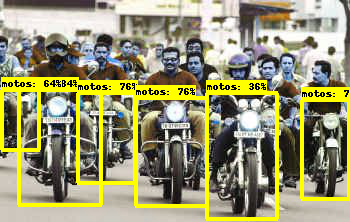

In [7]:
num_detections = int(detections.pop('num_detections'))

detections = {key: value[0,:num_detections].numpy() for key, value in detections.items()}

detections['num_detections'] = num_detections

detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'],
    detections['detection_classes'],
    detections['detection_scores'],
    category_index,
    max_boxes_to_draw = 200,
    min_score_thresh = 0.30,
    use_normalized_coordinates = True
)

cv2_imshow(image_np_with_detections)

In [8]:
image_path = "/content/10 (13).png"

image_np = np.array(Image.open(image_path))

input_tensor = tf.convert_to_tensor(image_np)
input_tensor = input_tensor[tf.newaxis, ...]

detections = detect_fn(input_tensor)

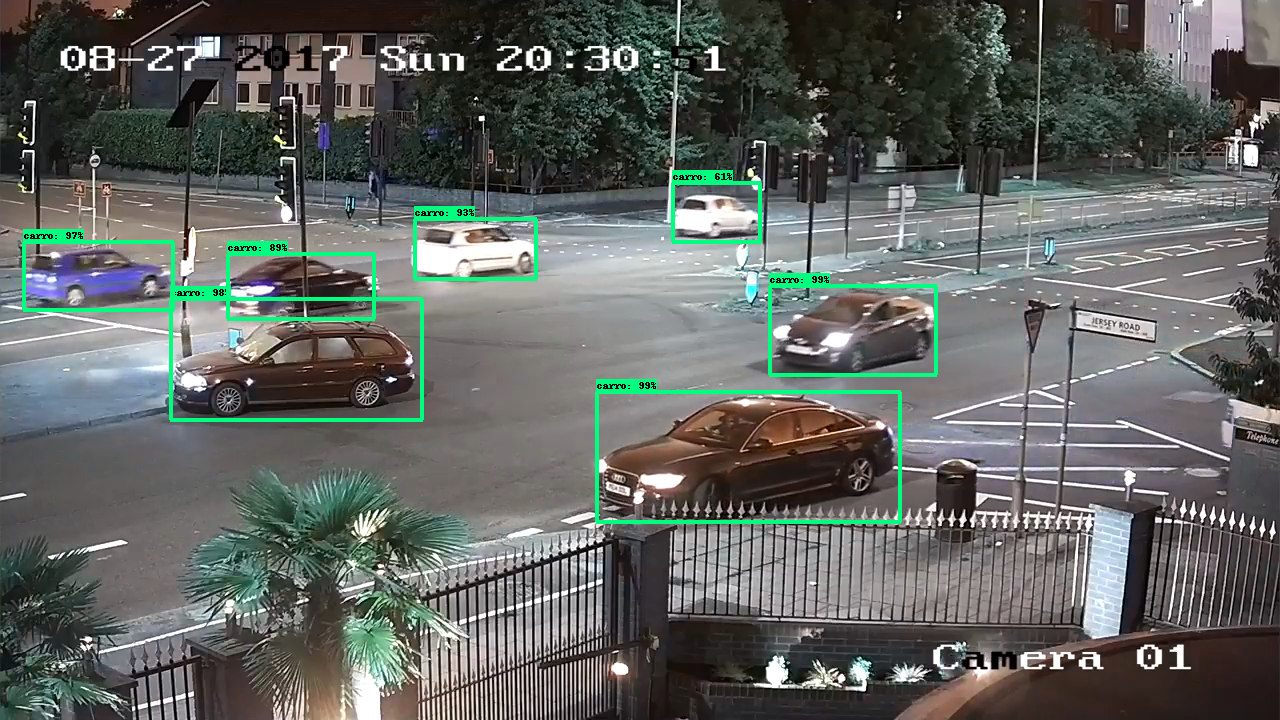

In [9]:
num_detections = int(detections.pop('num_detections'))

detections = {key: value[0,:num_detections].numpy() for key, value in detections.items()}

detections['num_detections'] = num_detections

detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'],
    detections['detection_classes'],
    detections['detection_scores'],
    category_index,
    max_boxes_to_draw = 200,
    min_score_thresh = 0.30,
    use_normalized_coordinates = True
)

cv2_imshow(image_np_with_detections)

In [11]:
import numpy as np
import argparse
import imutils
import time
import dlib
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from imutils.video import VideoStream
from imutils.video import FPS
from centroidtracker import CentroidTracker
from trackableobject import TrackableObject

In [15]:
from tensorflow.python.training.saver import trackable
PATH_VIDEO = "/content/test_video.mp4"

PATH_OUTPUT = "/content/video_out.mp4"

SKIP_FPS = 30
TRESHOLD = 0.3

vs = cv2.VideoCapture(PATH_VIDEO)

writer = None

W = int(vs.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(vs.get(cv2.CAP_PROP_FRAME_HEIGHT))

ct = CentroidTracker(maxDisappeared = 40, maxDistance = 50)

trackers = []
trackableObjects = {}

totalFrame = 0
totalDown = 0
totalUp = 0

DIRECTION_PEOPLE = True

POINT = [0, int((H/2)-H*0.1), W, int(H*0.1)]

fps = FPS().start()

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
writer = cv2.VideoWriter(PATH_OUTPUT, fourcc, 20.0, (W, H), True)

while True:
  ret, frame = vs.read()

  if frame is None:
    break

  status = "Waiting"
  rects = []


  if totalFrame % SKIP_FPS == 0:
    status = "Detecting"
    trackers = []
    
    image_np = np.array(Image.open(image_path))

    input_tensor = tf.convert_to_tensor(image_np)
    input_tensor = input_tensor[tf.newaxis, ...]

    detections = detect_fn(input_tensor)

    detection_scores = np.array(detections["detection_scores"][0])

    detection_clean = [x for x in detection_scores if x >= TRESHOLD]

    for x in range(len(detection_clean)): 
      idx = int(detections['detection_classes'][0][x])

      ymin, xmin, ymax, xmax = np.array(detections['detection_boxes'][0][x])
      box = [xmin, ymin, xmax, ymax] * np.array([W, H, W, H])

      (startX, startY, endX, endY) = box.astype("int")
      tracker = dlib.correlation_tracker()
      rect = dlib.rectangle(startX, startY, endX, endY)
      tracker.start_track(frame, rect)

      trackers.append(tracker)
    else:
      for tracker in trackers:

        status = "Tracking"

        tracker.update(frame)
        pos = tracker.get_position()

        startX = int(pos.left())
        startY = int(pos.top())
        endX = int(pos.right())
        endY = int(pos.bottom())

        rects.append((startX, startY, endX, endY))

    cv2.rectangle(frame, (POINT[0], POINT[1]), (POINT[0] + POINT[2], POINT[1] + POINT[3]), (255, 0, 255), 2)

    objects = ct.update(rects)

    for (objectID, centroid) in objects.items():
      to = trackableObjects.get(objectID, None)
      if to is None:
        to = TrackableObject(objectID, centroid)

      else:
        y = [c[1] for c in to.centroids]
        direction = centroid[1] - np.mean(y)
        to.centroids.append(centroid)

        if not to.counted:
          if centroid[0] > POINT[0] and centroid[0] < (POINT[0] + POINT[2]) and centroid[1] > POINT[1] and centroid[1] < (POINT[1]*POINT[3]):
            if DIRECTION_PEOPLE:
              if direction > 0:
                totalUp += 1
                to.counted = True
              else:
                totalDown += 1
                to.counted = True
            else:
              if direction < 0:
                totalUp += 1
                to.counted = True
              else:
                totalDown += 1
                to.counted = True

    trackableObjects[objectID] = to

    text = "ID {}".format(objectID)
    cv2.putText(frame, text, (centroid[0]-10, centroid[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
    cv2.circle(frame, (centroid[0], centroid[1]), 4, (0,255,0), -1)

  info = [
          ("Going up", totalUp),
          ("Going down", totalDown),
          ("Status", status),
    ]

  for (i, (k,v)) in enumerate(info):
      text = "{}: {}".format(k,v)
      cv2.putText(frame, text, (10, H - ((i*20) + 20)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

  writer.write(frame)

  totalFrame += 1
  fps.update()

fps.stop()

print("Full time {}".format(fps.elapsed()))
print("Approximate time per frame {}".format(fps.fps()))

writer.release()

vs.release()
  


Full time 6.717924
Approximate time per frame 49.866595692359724
